## Thousand Facial Landmarks Competition
В данном ноутбук немного разбираются аугментации, которые я использовал или пытался использовать.

P.S. в конце добавил немного выводов

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import pandas as pd
import torch
import torch.nn as nn
import PIL
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms.functional as TF
from IPython import display

np.random.seed(1234)

In [2]:
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [3]:
labels = []
with open("data/train/landmarks.csv", "r") as file:
    file.readline().split("\t")
    for i in range(10):
        labels.append(file.readline().split("\t"))

отобразим немного картинок из данных

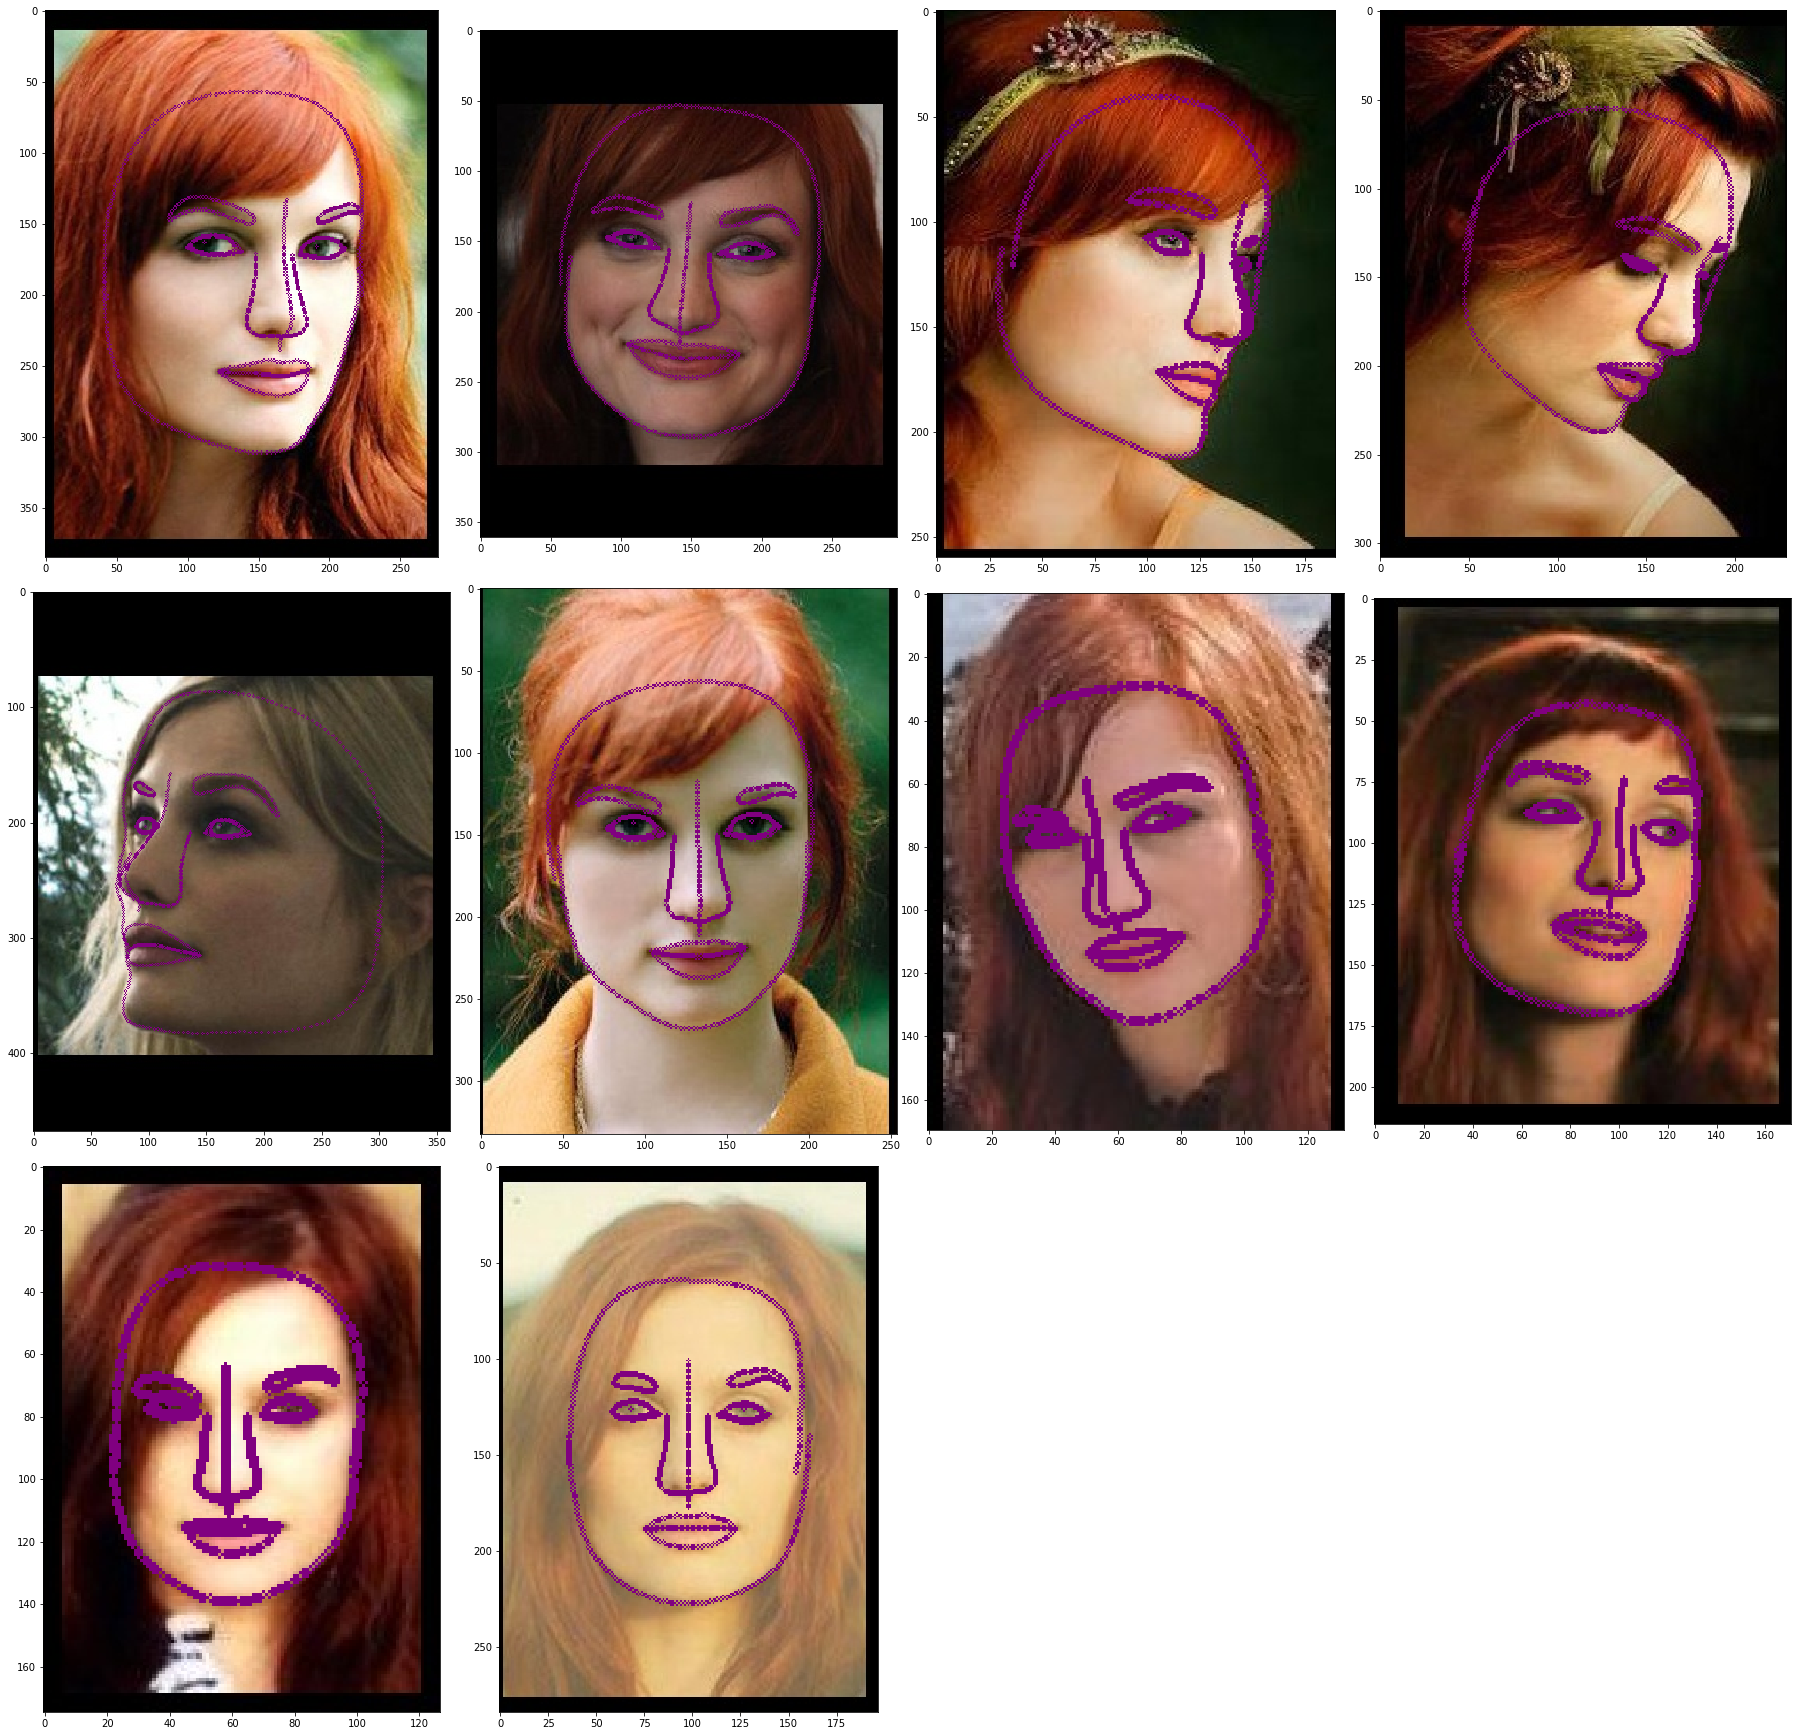

In [4]:
def draw_landmarks(image, landmarks):
    j = 0
    for i in range(len(landmarks)//2):
        x = int(landmarks[j])
        y = int(landmarks[j+1])
        j+=2
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(labels):
    path = os.path.join('data/train/images/', labels[i][0])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, labels[i][1:])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i+1)
    plt.imshow(image)

plt.tight_layout()
plt.show()

Очень много времени я потратил на попытки реализовать RandomHorizontalFlip. Я переписывал его разными
способами, пока не понял, что порядов лэндмарков тоже нужно менять. Внизу код, который рисует лэндмарки по одной
за раз.

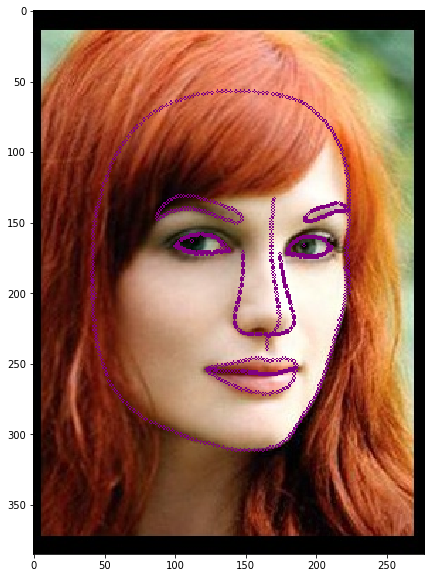

In [5]:
def step_by_step_draw(image, landmarks):
    i = 0
    while i < len(landmarks):
        plt.figure(figsize=(10, 10))
        image = draw_landmarks(image, landmarks[i:i+2])
        i += 2
        display.clear_output(wait=True)
        plt.imshow(image)
        plt.show()

ind = 0
path = os.path.join('data/train/images/', labels[ind][0])
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
landmarks = torch.tensor(np.array(labels[ind][1:]).astype(int))
step_by_step_draw(image, landmarks)

В результате наблюдений выявил такое расположение частей лица в лэндмарках:
1. labels[0:128] - левая нижняя часть овала лица (по часовой стрелке)
2. labels[128:546] - остальная часть лица, начиная снизу против часовой стрелки
3. labels[546:674] - левая бровь
4. labels[674:802] - правая бровь
5. labels[802:928] - левая линия носа
6. labels[928:1054] - правая линия носа
7. labels[1054:1174] - средняя линия носа
8. labels[1174:1428] - левый глаз (два прохода)
9. labels[1428:1682] - правый глаз (два прохода)
10. labels[1682:1938] - рот
11. labels[1938:1940] - левый зрачок
12. labels[1940:1942] - правый зрачок

In [6]:
def revert_landmarks(labels):
    print(labels.shape)
    new_labels = np.concatenate((
        labels[128:256],
        labels[0:128],
        np.flipud(labels[256:546].reshape(-1, 2)).reshape(-1),
        labels[674:802],
        labels[546:674],
        labels[928:1054],
        labels[802:928],
        labels[1054:1174],
        labels[1428:1682],
        labels[1174:1428],
        np.flipud(labels[1682:1746].reshape(-1, 2)).reshape(-1),
        np.flipud(labels[1746:1810].reshape(-1, 2)).reshape(-1),
        np.flipud(labels[1810:1874].reshape(-1, 2)).reshape(-1),
        np.flipud(labels[1874:1938].reshape(-1, 2)).reshape(-1),
        labels[1940:1942],
        labels[1938:1940]
    ))
    return torch.from_numpy(new_labels)

def flip_landmarks(labels, w):
    landmarks = labels.reshape(-1, 2)
    landmarks[:,0] = w - landmarks[:,0]
    labels = landmarks.reshape(-1)
    labels = revert_landmarks(labels)
    return labels

Здесь рисуется правильно перевернутая картинка с лэндмарками.

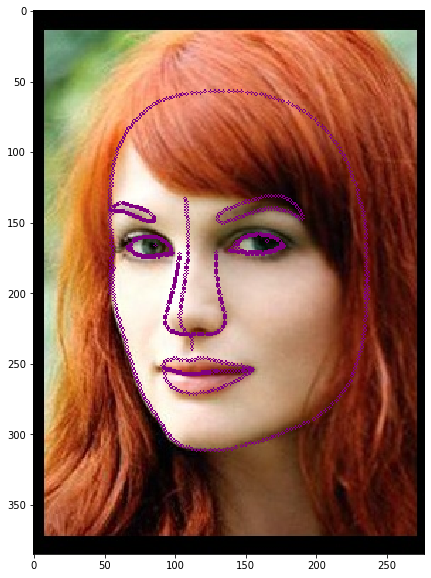

In [7]:
ind = 0
path = os.path.join('data/train/images/', labels[ind][0])
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.flip(image, 1)
_, w, _ = image.shape
landmarks = torch.tensor(np.array(labels[ind][1:]).astype(int))
landmarks = flip_landmarks(landmarks, w)
step_by_step_draw(image, landmarks)

Я много игрался с различными аугментациями, но не наигрался, так как обучения были долгими и стоили траты больших ресурсов.

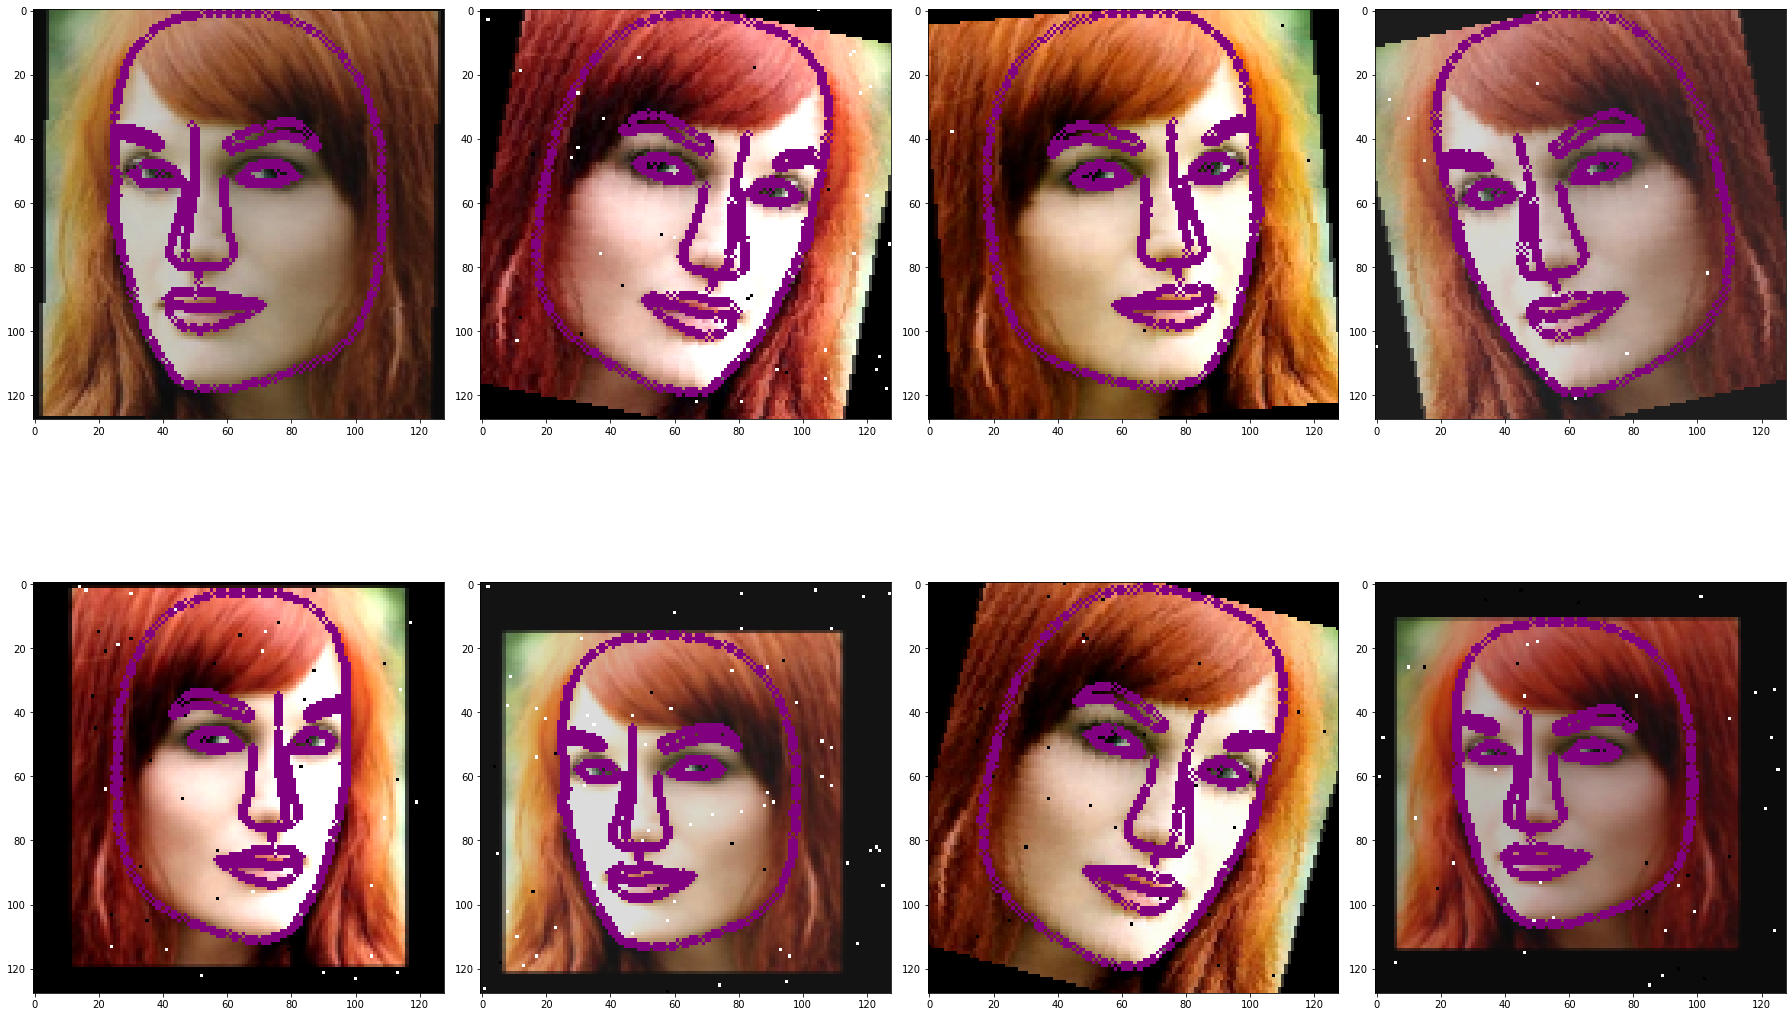

In [8]:
from hack_utils import *


train_transforms = transforms.Compose([
        RandomHorizontalFlip(p=0.5),
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        RandomApply([
            RandomPadAndResize(percent=0.15),
            RandomRotate(max_angle=15),
        ], p=[0.15, 0.85]),
        TransformByKeys(
            transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2, hue=0.03),
            ("image",)),
        TransformByKeys(transforms.RandomGrayscale(p=0.1), ("image",)),
        DropoutAugmentor(p=(0., 0.005))
    ])

plt.figure(figsize=(25, NUM_ROWS * 8))
for i in range(8):
    ind = 0
    path = os.path.join('data/train/images/', labels[ind][0])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    landmarks = torch.tensor([int(x) for x in labels[ind][1:]])
    sample = {'image': image, 'landmarks': landmarks}
    sample = train_transforms(sample)
    image, landmarks = sample['image'], sample['landmarks']
    
    image = np.array(image)
    image = draw_landmarks(image, landmarks)

    plt.subplot(NUM_ROWS, NUM_COLS, i+1)
    plt.imshow(image)

    plt.tight_layout()
plt.show()

В итоговой модели не использовался **RandomHorizonalFlip**, так как она не только не давала прироста к результату, но даже ухудшало его. Подогреваю, что в этих данных просто нельзя было использовать Flip.

Также, я решил в финальной версии убрать **DropoutAugmenter**, который рандомно сыпал соль и перец на картинку, так как у меня была последняя попытка использовать машину AWS и я не хотел рисковать, так как не знал в чем проблема: в HorizonalFlip или DropoutAugmenter. Однако, сейчас думаю, что она могла бы помочь с переобучением.

У меня не было достаточно возможности протестировать влияние и нужную пропорцию между **RandomPadAndResize** и **RandomRotate**, так как много времени и ресурсов убил на реализацию RandomHorizontalFlip. Однако, уверен, можно было подобрать более лучшие параметры и процентное соотношение для этих аугментаций.

Еще я хотел реализовать **RandomAffine**, а именно операцию **Shear**. Уверен, эта аугментация тоже могла бы внести свой вклад, так как можно наблюдать много картин в данных с повернутыми лицами. Однако, мне немного не хватило времени и мозгов завершить это дело.